## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import pickle

training_file = "/ts/train.p"
validation_file = "/ts/valid.p"
testing_file = "/ts/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
from collections import Counter
n_train = train['features'].shape[0]
n_validation = valid['features'].shape[0]
n_test = test['features'].shape[0]
image_shape = x_train[0].shape
n_classes = len(set(train['labels']))
freq = Counter(train['labels'])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(freq)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Counter({2: 2010, 1: 1980, 13: 1920, 12: 1890, 38: 1860, 10: 1800, 4: 1770, 5: 1650, 25: 1350, 9: 1320, 7: 1290, 3: 1260, 8: 1260, 11: 1170, 18: 1080, 35: 1080, 17: 990, 14: 690, 31: 690, 33: 599, 15: 540, 26: 540, 28: 480, 23: 450, 30: 390, 6: 360, 16: 360, 34: 360, 22: 330, 36: 330, 20: 300, 40: 300, 21: 270, 39: 270, 24: 240, 29: 240, 27: 210, 32: 210, 41: 210, 42: 210, 0: 180, 19: 180, 37: 180})


### Visualize the dataset

Image classification integer:  17


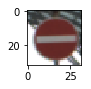

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

index = random.randint(0, len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print('Image classification integer: ', y_train[index])

----

## Step 2: Design and Test a Model Architecture

### Import tensorflow and define constants

In [4]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 512
KEEP_PROB = 0.80
LEARNING_RATE = 0.001
COLOR_CHANNELS = 3

### Augment dataset

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Scale({"height":32, "width":32})
], random_order=True) # apply augmenters in random order

In [6]:
augmented_x_train = np.array(seq.augment_images(x_train))
augmented_y_train = np.array(y_train)

print("Number of training examples =", augmented_x_train.shape[0])


Number of training examples = 34799


### Preprocess data

In [7]:
def normalize(x_train):
    x_train = np.array(x_train)
    x_train = (x_train - np.min(x_train)) / (np.max(x_train) - np.min(x_train))
    return x_train

In [8]:
def rgb_to_greyscale(image):
    return np.dot(image[...,:3], [0.299, 0.587, 0.114])

In [9]:
from sklearn.utils import shuffle
def process_data(x_data, y_data):
    if COLOR_CHANNELS == 1:
        x_data = rgb_to_greyscale(x_data)
        x_data = x_data.reshape(x_data.shape + (1,))
    x_data = normalize(x_data)
    x_data, y_data = shuffle(x_data, y_data)
    return (x_data, y_data)

In [10]:
x_train, y_train = process_data(augmented_x_train, augmented_y_train)
x_valid, y_valid = process_data(x_valid, y_valid)
x_test, y_test = process_data(x_test, y_test)

### Model Architecture

In [11]:
from tensorflow.contrib.layers import flatten

def traffic_signs(x):    
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, COLOR_CHANNELS, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    conv2 = tf.nn.relu(conv2)
    fc0   = flatten(conv2)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, KEEP_PROB)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    fc2    = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, COLOR_CHANNELS))
y = tf.placeholder(tf.int32, (None))
pred = traffic_signs(x)
one_hot_y = tf.one_hot(y, n_classes)

logits = traffic_signs(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(x_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic_lights')
    print("Model saved")
    
    training_accuracy = evaluate(x_train, y_train)
    validation_accuracy = evaluate(x_valid, y_valid)
    testing_accuracy = evaluate(x_test, y_test)
    print("Model accuracy:")
    print("Training Accuracy: {:.3f}".format(training_accuracy))
    print("Validation Accuracy: {:.3f}".format(validation_accuracy))
    print("Testing Accuracy: {:.3f}".format(testing_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.506

EPOCH 2 ...
Validation Accuracy = 0.729

EPOCH 3 ...
Validation Accuracy = 0.809

EPOCH 4 ...
Validation Accuracy = 0.837

EPOCH 5 ...
Validation Accuracy = 0.850

EPOCH 6 ...
Validation Accuracy = 0.857

EPOCH 7 ...
Validation Accuracy = 0.876

EPOCH 8 ...
Validation Accuracy = 0.882

EPOCH 9 ...
Validation Accuracy = 0.886

EPOCH 10 ...
Validation Accuracy = 0.895

EPOCH 11 ...
Validation Accuracy = 0.894

EPOCH 12 ...
Validation Accuracy = 0.902

EPOCH 13 ...
Validation Accuracy = 0.893

EPOCH 14 ...
Validation Accuracy = 0.906

EPOCH 15 ...
Validation Accuracy = 0.897

EPOCH 16 ...
Validation Accuracy = 0.906

EPOCH 17 ...
Validation Accuracy = 0.901

EPOCH 18 ...
Validation Accuracy = 0.910

EPOCH 19 ...
Validation Accuracy = 0.908

EPOCH 20 ...
Validation Accuracy = 0.912

EPOCH 21 ...
Validation Accuracy = 0.918

EPOCH 22 ...
Validation Accuracy = 0.912

EPOCH 23 ...
Validation Accuracy = 0.912

EPOCH 24 ...
Validation Accura

---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [16]:
from scipy import ndimage, misc

images = []
for i in range(1, 7):
    filepath = "./traffic-sign-examples/test_{}.png".format(i)
    image = ndimage.imread(filepath, mode="RGB")
    image_resized = misc.imresize(image, (32, 32))
    if COLOR_CHANNELS == 1:
        image_resized = rgb_to_greyscale(image_resized)
    images.append(image_resized)
images = np.array(images)
labels = np.array([1, 4, 7, 17, 30, 25])

Image class: 1
Title: Speed limit (30km/h)


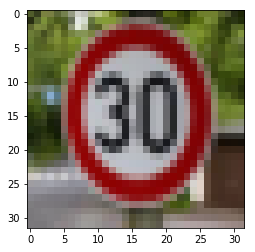

In [17]:
print("Image class: 1")
print("Title: Speed limit (30km/h)")
plt.imshow(images[0])

Image class: 4
Title: Speed limit (70km/h)


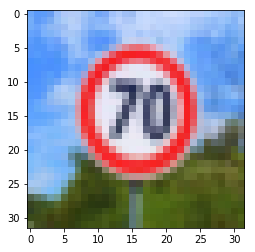

In [18]:
print("Image class: 4")
print("Title: Speed limit (70km/h)")
plt.imshow(images[1])

Image class: 7
Title: Speed limit (100km/h)


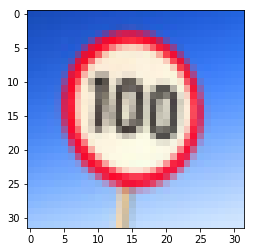

In [19]:
print("Image class: 7")
print("Title: Speed limit (100km/h)")
plt.imshow(images[2])

Image class: 17
Title: No entry


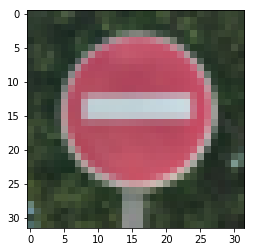

In [20]:
print("Image class: 17")
print("Title: No entry")
plt.imshow(images[3])

Image class: 30
Title: Beware of ice/snow


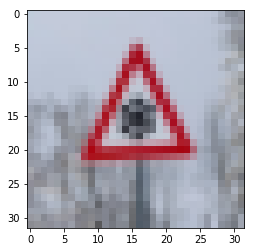

In [21]:
print("Image class: 30")
print("Title: Beware of ice/snow")
plt.imshow(images[4])

Image class: 25
Title: Road work


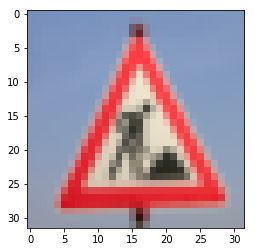

In [22]:
print("Image class: 25")
print("Title: Road work")
plt.imshow(images[5])

### Predict the Sign Type for Each Image

In [23]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred.eval(feed_dict = {x:images})

### Analyze Performance

In [31]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(images, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.500


### Output Top 5 Softmax Probabilities For Each Image

In [32]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_softmax_logits = sess.run(softmax_logits, feed_dict = {x:images})
    test_top_k = sess.run(top_k, feed_dict = {x:images})

    print(test_top_k)

TopKV2(values=array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]], dtype=float32), indices=array([[ 1,  0,  2],
       [ 1,  0,  2],
       [ 2,  0,  1],
       [17,  0,  1],
       [31,  0,  1],
       [25,  0,  1]], dtype=int32))
